<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/Phone_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 경로 설정
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset'

def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)   # (samples, timesteps, features)

def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    filenames = []
    filenames += [f'total_acc_x_{group}.txt', f'total_acc_y_{group}.txt', f'total_acc_z_{group}.txt']
    filenames += [f'body_acc_x_{group}.txt',  f'body_acc_y_{group}.txt',  f'body_acc_z_{group}.txt']
    filenames += [f'body_gyro_x_{group}.txt', f'body_gyro_y_{group}.txt', f'body_gyro_z_{group}.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + f'/y_{group}.txt')
    return X, y

def load_dataset(prefix=BASE_PATH):
    trainX, trainy = load_dataset_group('train', prefix)
    testX,  testy  = load_dataset_group('test',  prefix)

    # 라벨 1~6 → 0~5
    trainy = trainy - 1
    testy  = testy - 1

    trainy_oh = to_categorical(trainy)
    testy_oh  = to_categorical(testy)

    print('trainX:', trainX.shape,
          'trainy:', trainy.shape,
          'testX:', testX.shape,
          'testy:', testy.shape)

    return trainX, trainy, trainy_oh, testX, testy, testy_oh

# 데이터 로드
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-3277430429.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3277430429.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3277430429.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3277430429.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-32774

trainX: (7352, 128, 9) trainy: (7352, 1) testX: (2947, 128, 9) testy: (2947, 1)


In [ ]:
# 2. train/val 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy_one_hot,
    test_size=0.2,
    random_state=100,
    stratify=trainy_one_hot
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 입력/출력 차원
n_timesteps = X_train.shape[1]   # 128
n_features  = X_train.shape[2]   # 9
n_outputs   = y_train.shape[1]   # 6

(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [ ]:
# 3. GRU 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(n_outputs, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,174 (371.77 KB)

 Trainable params: 95,174 (371.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4. 학습
history = gru_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4529 - loss: 1.3205 - val_accuracy: 0.6241 - val_loss: 0.9009
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6992 - loss: 0.7186 - val_accuracy: 0.9361 - val_loss: 0.1889
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9247 - loss: 0.2052 - val_accuracy: 0.9313 - val_loss: 0.1614
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9412 - loss: 0.1499 - val_accuracy: 0.9422 - val_loss: 0.1518
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9416 - loss: 0.1400 - val_accuracy: 0.9531 - val_loss: 0.1408
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9460 - loss: 0.1412 - val_accuracy: 0.9456 - val_loss: 0.1432
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9430 - loss: 0.1365 - val_accuracy: 0.9504 - val_loss: 0.1370
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9488 - loss: 0.1247 - val_accu

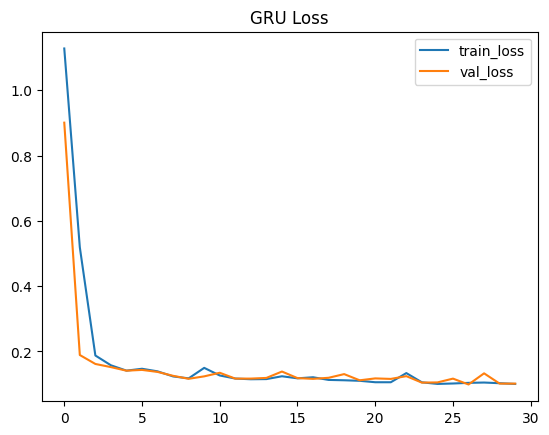

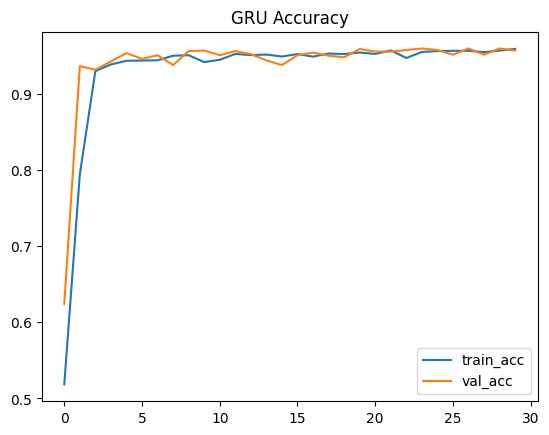

In [ ]:
# 5. 학습 곡선
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('GRU Loss')
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('GRU Accuracy')
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
GRU test accuracy: 0.9178825924669155
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       496
           1       0.87      1.00      0.93       471
           2       0.96      0.98      0.97       420
           3       0.80      0.85      0.83       491
           4       0.90      0.81      0.85       532
           5       0.99      0.96      0.98       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



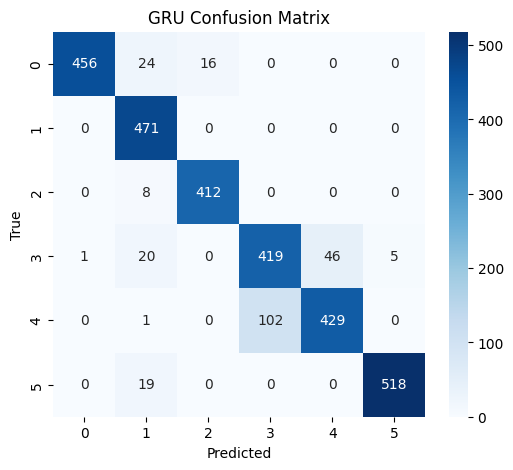

In [ ]:
# 6. 테스트셋 평가
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_prob = gru_model.predict(testX)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = testy.ravel()

print("GRU test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GRU Confusion Matrix")
plt.show()